# Introduction to Maching Learning: Final Project, Capital Bikeshare

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.
The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

# Import Libraries, read in Kaggle data & features from other sources

In [1]:
# Importing the libraries and datasets.
# Does not yet inclue Theano libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy import stats
from datetime import datetime
#from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
import copy
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline


# The Kaggle data
full = pd.read_csv('~/datasets/bikeshare/train.csv')
test = pd.read_csv('~/datasets/bikeshare/test.csv')

# External Datasets
wmata_delay=pd.read_csv('~/datasets/bikeshare/wmata_delay_wrangled.csv')
light_data=pd.read_csv('~/datasets/bikeshare/WeatherObsDCNoPrecip.csv')
time_series=pd.read_csv('~/datasets/bikeshare/Time_Series_formatted.csv')

print(full.shape)
print(test.shape)
print(wmata_delay.shape)
print(light_data.shape)
print(time_series.shape)

(10886, 12)
(6493, 9)
(14257, 8)
(17544, 25)
(104, 4)


In [2]:
# Here is the funtion to evaluate Root Mean Square Logarithmic Error (RMSLE) for regression analysis

def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))


# Let's look at what we have to work with: Full training data from Kaggle

In [3]:
# Let's take a look at the training data from Kaggle.

print(list(full))
print(full.dtypes)

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


# Generating the Baseline

To generate a baseline, we are calculating the average number of total riders per hour, across every day.  This was our baseline submission, using mean ridership per hour as the baseline.

The date/time stamp from Kaggle has good information, but not in this form.  We expect that the hour of the day will be correlated with the number of riders, both casual and registered. We also think that the day of the week may have more predictive power than just "weekday" or "weekend".  Let's extract as much information from the datetime stamp as possible.

In [4]:
# Separating the datetime field into separate date and time (hour) columns for train and test.
full["date"] = full.datetime.apply(lambda x : x.split()[0])
full["hour"] = full.datetime.apply(lambda x : x.split()[1].split(":")[0])

test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])

full.hour = full.hour.astype(int)
test.hour = test.hour.astype(int)

#  Calculate the hourly averages and save as "averages"
averages = full.groupby(['hour']).mean()

# Only save the appropriate columns
averages = averages.ix[:,'casual':]

# Rename the index, and adding the hours column
averages.index.names = ['index']
hour = {'hour': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}
df_hour = pd.DataFrame(hour, columns = ['hour'])
averages = pd.merge(averages, df_hour, right_index=True, left_index=True)

# Here is the resulting dataset - the average number of riders per hour, across all days.
print('Information on the Baseline Calculations:')
print(averages.dtypes)
print(averages[:5])
print("===========================================")
print()

# Now we need to use a join function to insert the average riders per day,
# to predict the test set.

submission = test.merge(averages, on='hour')
submission = submission.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour', 'casual', 'registered'], axis=1)
submission = submission.set_index('datetime')
print('Information on the Baseline Submission:')
print(submission.dtypes)
print(submission[:5])

# Printing to text file
# This is our baseline submission

submission.to_csv('~/datasets/bikeshare/average_usage_baseline.csv', sep=',')

Information on the Baseline Calculations:
casual        float64
registered    float64
count         float64
hour            int64
dtype: object
          casual  registered      count  hour
index                                        
0      10.312088   44.826374  55.138462     0
1       6.513216   27.345815  33.859031     1
2       4.819196   18.080357  22.899554     2
3       2.681293    9.076212  11.757506     3
4       1.262443    5.144796   6.407240     4

Information on the Baseline Submission:
count    float64
dtype: object
                         count
datetime                      
2011-01-20 00:00:00  55.138462
2011-01-21 00:00:00  55.138462
2011-01-22 00:00:00  55.138462
2011-01-23 00:00:00  55.138462
2011-01-24 00:00:00  55.138462


# Plotting the Data

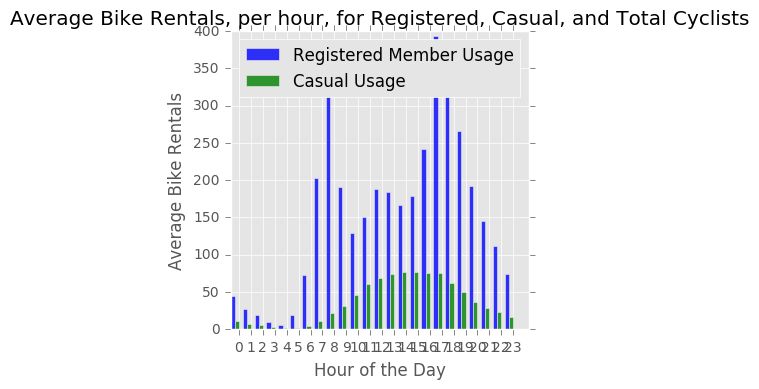

In [5]:
# Let's plot the data
n_groups = 24
casual = averages['casual']
registered = averages['registered']
 
# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, registered, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Registered Member Usage')
 
rects2 = plt.bar(index + bar_width, casual, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Casual Usage')
 
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Rentals')
plt.title('Average Bike Rentals, per hour, for Registered, Casual, and Total Cyclists')
plt.xticks(index + 2*bar_width, index)
plt.legend()
 
plt.tight_layout()
plt.show()

# Let's look at external datasets which may provide additional information:

1. External Light and Weather Data
2. Mass Transit Data (from WMATA)
3. Additional Light and Weather Information from timeanddate.com
4. Calculating prior hour's weather information as a new feature for each observation

# External Light and Weather Data

In [6]:
# Let's look at the additional features we engineered about light and weather
#
# Source for 2011 Weather Data: https://www1.ncdc.noaa.gov/pub/data/noaa/2011/724050-13743-2011.gz
# Source for 2012 Weather Data: https://www1.ncdc.noaa.gov/pub/data/noaa/2012/724050-13743-2012.gz
# USAF Weather Station: 724050
# WBAN Weather Station Code: 13743
#
# This weather is for Regan International Airport, the closest weather station to Washington DC
#
# Also added daylight information
# 
# Source for light data: https://www.timeanddate.com/sun/usa/washington-dc?month=12&year=2011
# 
# The API was $50.00, so cut and pasted the data for each month from the site above 
# (reference link is for December, 2011 -- only one month of data was displayed at a time)
#
# Daylight was defined using Nautical Twilight and sunrise/sunset as follows:
#
# Hours before morning Nautical Twilight or after evening Nautical Twilight are consdiered Dark
# Hours after sunrise and before sunset are considered Light
# Hours that have at least 15 minutes that occur between am Nautical Twilight and sunrise or 
# sunset and pm Nautical Twilight are considered Twilight
#
# The theory is that people will be more likely to rent a bike when it is light.  Hour of day 
# can't be used b/c of seasonality in light and daylight savings time we will see if this adds anything!

print("Fields for addl light and weather features")
print("===========================================")
print(light_data.dtypes)
print("===========================================")
print()

# we don't need the quality control columns, as those were for checking the excel
# we also renamed the light/dark/twighlight features, so we don't need the duplicates
# We also have binarized some of the data, so we don't need the source fields

light_data.hour = light_data.hour.astype(np.int32)
light_data = light_data.drop(['dayOfWeekQC', 'LightQC', 'dayOfWeek', 'light'], axis=1)

# Now lets see what we have again

print("Updated Fields for addl light and weather features")
print("===========================================")
print(list(light_data))
print("===========================================")
print(light_data.dtypes)


Fields for addl light and weather features
year                   int64
month                  int64
day                    int64
yyyymmdd               int64
date                  object
dayNum                 int64
dayOfWeek              int64
isSun                  int64
isMon                  int64
isTues                 int64
isWeds                 int64
isThurs                int64
isFri                  int64
isSat                  int64
dayOfWeekQC            int64
hour                   int64
light                 object
isLight                int64
isDark                 int64
isTwilight             int64
LightQC                int64
ceilingHeight          int64
visibilityDistance     int64
dewPoint               int64
seaLevelPressure       int64
dtype: object

Updated Fields for addl light and weather features
['year', 'month', 'day', 'yyyymmdd', 'date', 'dayNum', 'isSun', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'hour', 'isLight', 'isDark', 'isTwilight', '

# Adding Additional Features from Data

In [7]:
###############################################################################################
# Next two features I had problems coding, so engineered them in excel and merged in with Light data
#
# dayOfWeek and dayNum -- a rising column incremented by 1 for each day
###############################################################################################

# Weekday feature extraction to be added -- code not working, so engineered in Excel (see above)
# in accordance with permission granted in email.
#
# Python treats x as a string, so we can't use datetime functions on it, but
# when passed, it appears to be passed as a datetime object
# Code commented out due to errors

# train["dayOfWeek"] = train.datetime.apply(lambda x: datetime.strptime(x,'%w'))

# Rising daynum to be added -- code not working  -- code not working, so engineered in Excel (see above)
# in accordance with permission granted in email.
#
# Python treats x as a string, so we can't use datetime functions on it, but
# when passed, it appears to be passed as a datetime object
# Code commented out due to errors -- this sample done as the other way it breaks
# We don't want to run a for loop, but can't seem to find the correct approach

# train["dayNum"] = train.datetime.apply(lambda x: x.to_ordinal())
#
# This problem was solved by adding these fields to the additional Weather Observations see merge
# of light_data below -- Explanation of how data derived in first tab of .xlsx 

print('For the full/training dataset:')
print("===========================================")
print(full.shape)
print("===========================================")
print(list(full))
print("===========================================")
print(full.dtypes)
print()
print()
print('For the test dataset:')
print("===========================================")
print(test.shape)
print("===========================================")
print(list(test))
print("===========================================")
print(test.dtypes)

For the full/training dataset:
(10886, 14)
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'hour']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
date           object
hour            int32
dtype: object


For the test dataset:
(6493, 11)
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
date           object
hour            int32
dtype: object


# Merge in Partial Mass Transit Data

In [8]:
# We believe that delays in mass transit could cause more people to ride bikes
# So we found a data source (WMATA). However, the data is only available for the last 9 months
# of our time period.

print("From the external dataset from WMATA: Washington Metropolitan Area Transit Authority:")
print("===========================================")
print(wmata_delay.dtypes)
print("===========================================")
print()
print()

# Merging in external data from DC Metro (WMATA).
# Let's see if transit delays/outages affect cycling ridership in our bikeshare data. 

fullWithWMATA = pd.merge(full, wmata_delay, how='left', left_on=['date','hour'], right_on = ['date','hour'])
fullWithWMATA.drop_duplicates(['datetime'], keep='last')
testWithWMATA = pd.merge(test, wmata_delay, how='left', left_on=['date','hour'], right_on = ['date','hour'])
testWithWMATA.drop_duplicates(['datetime'], keep='last')

## The delay_collapsed variable is the one we are using for this analysis (will delays affected bikeshare ridership?).
## Only 10% of the hours in our dataset had metro delays so the rest are 
# merged in as NaN. We replace those with 0.

fullWithWMATA['delay_collapsed']=fullWithWMATA['delay_collapsed'].fillna(0)
testWithWMATA['delay_collapsed']=testWithWMATA['delay_collapsed'].fillna(0)

# Print what the new datasets look like:

print("The merged dataset - training plus WMATA:")
print("===========================================")
print(fullWithWMATA.shape)
print("===========================================")
print(fullWithWMATA.dtypes)
print("===========================================")
print()
print("The merged dataset - test plus WMATA:")
print("===========================================")
print(testWithWMATA.shape)
print("===========================================")
print(testWithWMATA.dtypes)
print("===========================================")

# Export to csv.
fullWithWMATA.to_csv('~/datasets/bikeshare/merge_wmata_full_data_test.csv', sep=',')
testWithWMATA.to_csv('~/datasets/bikeshare/merge_wmata_test_data_test.csv', sep=',')


From the external dataset from WMATA: Washington Metropolitan Area Transit Authority:
date                object
hour                 int64
Incident            object
Line                object
Direction           object
Cause               object
Delay              float64
delay_collapsed    float64
dtype: object


The merged dataset - training plus WMATA:
(10886, 20)
datetime            object
season               int64
holiday              int64
workingday           int64
weather              int64
temp               float64
atemp              float64
humidity             int64
windspeed          float64
casual               int64
registered           int64
count                int64
date                object
hour                 int32
Incident            object
Line                object
Direction           object
Cause               object
Delay              float64
delay_collapsed    float64
dtype: object

The merged dataset - test plus WMATA:
(6493, 17)
datetime            obje

# Merge in light data and other weather variables

In [9]:
# We believe that the light might make a difference to ridership
# Using data from timeanddate.com, we have calculated each hour as being light, dark or twilight
# Using nautical twilight as the guide, we designated an hour as twilight if it had at least 15 minutes of twilight
# during it.  Daytime was the hours between sunrise and sunset, and Dark was the time between nautical twilight
# in the eve and nautical twilisght in the morning.
#
# This resulted in 1 or two hours each morning and night being considered twilight
# Data was copy and pasted into excel and then wrangled there

# This cell is to merge that data into our dataset

fullWithExtFeats = pd.merge(fullWithWMATA, light_data, how='left', left_on=['date','hour'], right_on = ['date','hour'])
testWithExtFeats = pd.merge(testWithWMATA, light_data, how='left', left_on=['date','hour'], right_on = ['date','hour'])

# Let's see what the data looks like now:
print("The TRAINING dataset, plus WMATA and TimeAndDate.com:")
print("===========================================")
print(fullWithExtFeats.shape)
print("===========================================")
print(fullWithExtFeats.dtypes)
print("===========================================")
print()
print("The TEST dataset, plus WMATA and TimeAndDate.com:")
print("===========================================")
print(testWithExtFeats.shape)
print("===========================================")
print(testWithExtFeats.dtypes)
print("===========================================")

# Export to CSV:
fullWithExtFeats.to_csv('~/datasets/bikeshare/merge_light_full_data.csv', sep=',')
testWithExtFeats.to_csv('~/datasets/bikeshare/merge_light_test_data.csv', sep=',')


The TRAINING dataset, plus WMATA and TimeAndDate.com:
(10886, 39)
datetime               object
season                  int64
holiday                 int64
workingday              int64
weather                 int64
temp                  float64
atemp                 float64
humidity                int64
windspeed             float64
casual                  int64
registered              int64
count                   int64
date                   object
hour                    int32
Incident               object
Line                   object
Direction              object
Cause                  object
Delay                 float64
delay_collapsed       float64
year                    int64
month                   int64
day                     int64
yyyymmdd                int64
dayNum                  int64
isSun                   int64
isMon                   int64
isTues                  int64
isWeds                  int64
isThurs                 int64
isFri                   int64
isSa

# Add the prior hour's weather as a feature of each observation

In [10]:
###########################################
# Now that we have a fully merged dataset with all the engineered features, 
# we want to add some of the prior hour's information, and two hours before,
# but then we have to deal with missing observations
#
# There are 42 missing observations in the full training data for the days we are looking at
# and, additionally, all days from the end of the month are missing, since they are in the test
# set so the first observation (midnight) for the first of the month for every month will be missing.
#
# Proposed approach is to average fields that can be averaged: temp, atemp, humidity, and windspeed 
# as well as the continuous variables from the weather data.
# The weather code will be assumed to be the same as the weather from the observation two hours before.
########################

####################################################
# Method:
# 
# Add a column for previous row's date hour and weather to all records, then
# determine if the prior record is the "hour before's" weather
# If it isn't, it is either because of a missing observation, in which case 
# the observation is from two hours before
# or it is because it is the first observation of the month
###################################

#################################
# This is a lot of code, so make it a function so we can
# run it on the training and test sets separately
#################################

def gen_prior_data(myDataFrame):
    
    # renamne the data set and ensure it is sorted
    sortedDF = myDataFrame.sort_values(['date', 'hour'], ascending=[True, True])

    # Now we need to create the columns for the previous hour's weather, and
    # populate with the earlier respectve value.
    sortedDF['prev_atemp']=sortedDF.atemp.shift()
    sortedDF['prev_ceilingHeight']=sortedDF.ceilingHeight.shift()
    sortedDF['prev_dewPoint']=sortedDF.dewPoint.shift()
    sortedDF['prev_humidity']=sortedDF.humidity.shift()
    sortedDF['prev_seaLevelPressure']=sortedDF.seaLevelPressure.shift()
    sortedDF['prev_temp']=sortedDF.temp.shift()
    sortedDF['prev_visibilityDistance']=sortedDF.visibilityDistance.shift()
    sortedDF['prev_weather']=sortedDF.weather.shift()
    sortedDF['prev_windspeed']=sortedDF.windspeed.shift()
    sortedDF['prev_hour']=sortedDF.hour.shift()
    sortedDF['prev_date']=sortedDF.date.shift()
    sortedDF['prev_month']=sortedDF.month.shift()

    # Now we need to handle edge conditions, and missing observations gracefully
    
    # create a list of all "previous" column names
    filter_col = [col for col in list(sortedDF) if col.startswith('prev_')]
    print(filter_col)
    
    # check for missing observations

    # missing observations:  Prior fields will need to be averaged from hour before and current hour
    missing_mask = sortedDF['hour'] != ((sortedDF['prev_hour']+1)% 24)
    
    # check for first observation of the month -- 
    # since the test data is the data from the last days of the month,
    # the previous hour data for the first observation of each month is just plain wrong.
    # we will using the current observation.  We would have used the NOAA prior hour data, 
    # but there is no more time, and we dropped those variables b/c they were redundant
    first_obs = sortedDF['month'] == ((sortedDF['prev_month'])%12 +1) 

    # We need to fill in the values for teh very first observation now so there are no nan.
    # We will just replace it with the second value, as we can't really do anything else
    # replace nan at start of test set for random forest
    for col in filter_col:

        test_value=sortedDF[col].iloc[[0]].values
        test_value1=test_value[0]


        if np.isnan(test_value1):
            #print(sortedDF[col].iloc[[0]], "look here")
            replacement_value=sortedDF[col].iloc[[1]].values
            replacement_value1=replacement_value.tolist()

            replacement_value2=replacement_value1[0]

            sortedDF.loc[0,col] = replacement_value2
        else:
            print("Not missing")

    # replace values with prior observations missing with average

    # remove hour, day and date from the list of fields as these do not need to be calculated
    # they were only included in the list to facilitate the identification of records that 
    # needed to be cleansed
    del filter_col[-3:]

    # also remove weather, as that is categorical, not continuous
    del filter_col[-2:1]

    # generate the corresponding names of the source or current columns
    source_col=[col[5:] for col in filter_col]

    # get the missing observations
    priorMissingObsDF=sortedDF.loc[missing_mask,source_col+filter_col]

    source_data=np.array(priorMissingObsDF[source_col])
    prev_data=np.array(priorMissingObsDF[filter_col])

#     print(source_data[:5])
#     print(prev_data[:5])
# # 
#     The commented out code below did not work, I don't understand why, based on the documentation
    # newwind=(np.array(mytest['windspeed'])+np.array(mytest['prev_windspeed']))/2
    # mytest.assign(prev_windspeed=newwind)

    # but this did work to assign values, and assigned the values in the source dataset
    # which is the behavior we want
    priorMissingObsDF.loc[:,filter_col]=(source_data+prev_data)/2
    
    # print out a few values we know the answer to
#     print(priorMissingObsDF.loc[:,'prev_windspeed'][:5])
#     print(sortedDF.loc[29,'prev_windspeed'])
    
    # the categorical variable weather does not need to be modified, as we are taking the data from the 
    # observation two hours before
    
    # But we do need to fix our start of month records
    
    # get the start of month observations
    firstObsDF=sortedDF.loc[first_obs,source_col+filter_col]

    source_data=np.array(firstObsDF[source_col])

    # set the previous hour's data to the current data
    firstObsDF.loc[:,filter_col]=source_data
    
    # for the first observation of every month, we do need to fix the previous hour's weather data, as it is 
    # the last observation from the 19th of the month before
    
    sortedDF.loc[first_obs, 'prev_weather']=sortedDF.loc[first_obs, 'weather']

    return sortedDF

# Call our function on training dataset
sortedFull = gen_prior_data(fullWithExtFeats)

# Call our function on test dataset
sortedTest = gen_prior_data(testWithExtFeats)

['prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'prev_hour', 'prev_date', 'prev_month']
['prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'prev_hour', 'prev_date', 'prev_month']


# Basic Exploratory Data Analysis 

Ideas:

Weekday/Weekend/Holiday - Extracting 'Day of Week' from datetime and see if there is a difference.
Hypothesis - Casual Riders will increase during the weekend due to recreational habits, and 
registered riders will decrease due to assumption that registered riders use bikes to commute.

Weather - Which of the weather factors affect rider numbers, if any?  

Season/Holiday - Which, if any, seasons affect rider numbers?  In DC, the nicest weather is spring and fall - is this
represented in the data?  Summer is very, very hot, so I would assume registered riders would use the service in the 
evening commute, and casual riders would increase in the spring/summer, since those are the heaviest tourist seasons.

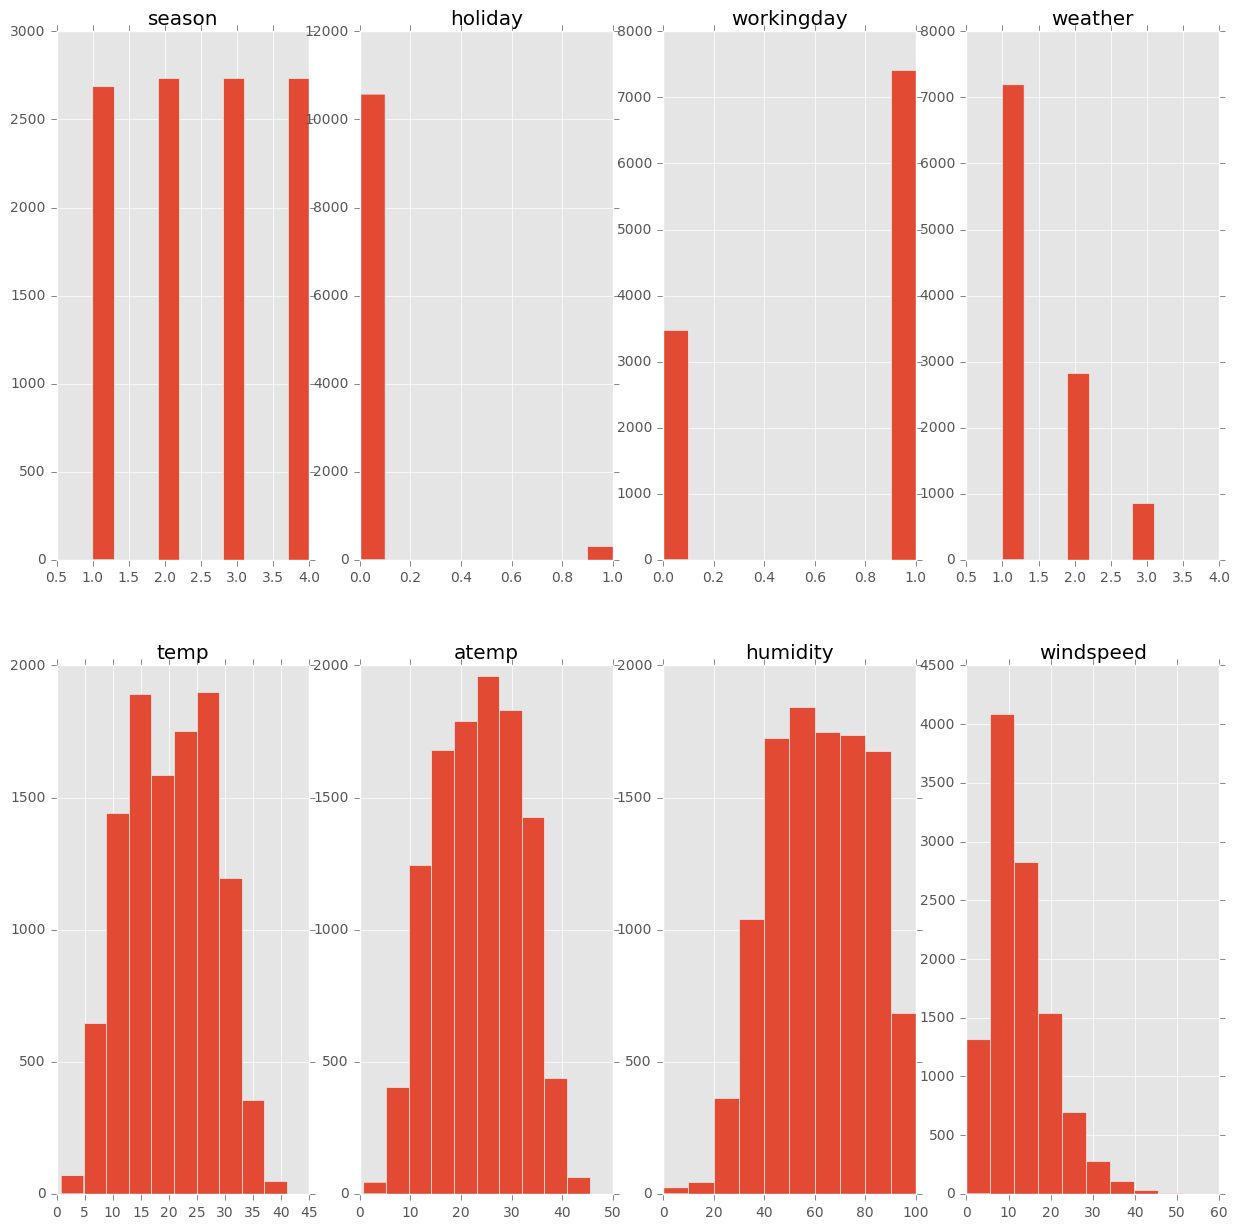

In [11]:
#Basic EDA, we can expand beyond these eight variables, now that the data is fully merged.
# Now, we need to figure out which variables affect ridership the most,
# thereby determining which factors are best to use for our model.
# Here are histograms of 8 different variables.

num_vars=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
plt.figure(figsize=(15,15), dpi=150)
for i, var in enumerate(num_vars):
    j=i+1
    plt.subplot(2,4,j) 
    full[var].hist()
    plt.title(var)

The histograms reveal that season is almost equal distribution, which makes sense, since this is timeseries data, and the seasons are each about the same length (count per season might be more informative) weather type 1 (Clear, Few clouds, Partly cloudy, Partly cloudy) is dominant, atemp appears to be normally distributed with a peak riding temperate of about 25 degrees and windspeed appears to be inversely correlated with ridership.

# Basic Regression Analysis

In [12]:
# Keep this random seed here to make comparison easier.
np.random.seed(785)

# Dividing our training data into training and development sets.
msk = np.random.rand(len(full)) < 0.8
train = fullWithWMATA[msk]
dev=fullWithWMATA[~msk]
print ('Training set shape: ', train.shape)
print ('Dev set  shape: ', dev.shape)

Training set shape:  (8715, 20)
Dev set  shape:  (2171, 20)


In [13]:
#  What are the best variable(s) for registered cyclists from the original data?

registered_report=[]
for var in num_vars:
    X_train = train[var]
    X_dev = dev[var]

    Y_train = train['registered']
    Y_dev = dev['registered']

    X_train1=X_train.values.reshape(-1, 1)
    Y_train1=Y_train.values.reshape(-1, 1)
    Y_dev1=Y_dev.values.reshape(-1, 1)
    X_dev1=X_dev.values.reshape(-1, 1)


    # Create linear regression object
    #regr = linear_model.LinearRegression() (Jordan...I got an error doing this...)
    #So I modified to this... is this correct?  
    regr = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regr.fit(X_train1, Y_train1)
    preds = regr.predict(Y_dev1)

    # The coefficients
    #print('Coefficients: \n', regr.coef_[0][0])
    coef=regr.coef_[0][0]
    
    # The mean squared error
    #print("Mean squared error: %.2f"
         # % np.mean((preds) - Y_dev1) ** 2)
    mse=int(np.mean((preds) - Y_dev1) ** 2)
    
    # Explained variance score: 1 is perfect prediction
    #print('Variance score: %.2f' % regr.score(X_dev1, Y_dev1))
    var_score=regr.score(X_dev1, Y_dev1)
    registered_report.append([var, coef, mse, var_score])

print ("For registered cyclists:")
print ("Variable, coefficient, MSE, Variable score")
for i in registered_report:
    print( i)
print('_____________________________________________________________________')   
    
#  What are the best variable(s) for casual cyclists?

casual_report=[]
for var in num_vars:
    X_train = train[var]
    X_dev = dev[var]

    Y_train = train['casual']
    Y_dev = dev['casual']

    X_train1=X_train.values.reshape(-1, 1)
    Y_train1=Y_train.values.reshape(-1, 1)
    Y_dev1=Y_dev.values.reshape(-1, 1)
    X_dev1=X_dev.values.reshape(-1, 1)


    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train1, Y_train1)

    preds = regr.predict(Y_dev1)
    # The coefficients
    #print('Coefficients: \n', regr.coef_[0][0])
    coef=regr.coef_[0][0]
    # The mean squared error
    #print("Mean squared error: %.2f"
         # % np.mean((preds) - Y_dev1) ** 2)
    mse=int(np.mean((preds) - Y_dev1) ** 2)
    # Explained variance score: 1 is perfect prediction

    #print('Variance score: %.2f' % regr.score(X_dev1, Y_dev1))
    var_score=regr.score(X_dev1, Y_dev1)
    
    casual_report.append([var, coef, mse, var_score])

print ("For casual cyclists:")
print ("Variable, coefficient, MSE, Variable score")
for i in casual_report:
    print( i)

For registered cyclists:
Variable, coefficient, MSE, Variable score
['season', 22.346629555687997, 11810880, 0.026044630275451564]
['holiday', -19.039184998659231, 8862700, 0.00042761760039833341]
['workingday', 39.325073290646024, 37457871, 0.012359691610277057]
['weather', -24.167930005477306, 14026235, 0.01845181800144835]
['temp', 6.1295060692318355, 693818, 0.10875595788307968]
['atemp', 5.5356287821314147, 537581, 0.11027371954497277]
['humidity', -2.0848319580928605, 39193, 0.071878209711964791]
['windspeed', 1.7391023263732592, 61785, 0.0060854281445765768]
_____________________________________________________________________
For casual cyclists:
Variable, coefficient, MSE, Variable score
['season', 4.3438850570713967, 22404, 0.0073813127152221325]
['holiday', 11.957335128644457, 197612, 0.0019757421557516919]
['workingday', -33.232403847075147, 1488386, 0.10946339550393036]
['weather', -10.583710750707986, 145837, 0.017307608948005981]
['temp', 2.9583504949463855, 2382, 0.2143

We found that temperature is the most predictive basic feature for both registered and casual riders based on the variance score but this is not consistent with the mean square error.

# Time Series Analysis

In [14]:
# Ridership increases over time, so we wanted to analyze that and see what we could find
# 
###time series regression, make the dataframes
##wanted to do by week but the fact that the last week of each month is omitted is problematic. 
# from datetime import datetime -- imported in first cell

##make a train set by week
trainTS = train.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'datetime', 'hour', 'casual', 'registered'], axis=1)
trainTS["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in trainTS["date"] ]
trainTS.index=trainTS['date1']


trainByWeek=trainTS.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.week]).sum()


##make a dev set by month
devTS = dev.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'datetime', 'hour', 'casual', 'registered'], axis=1)
devTS["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in devTS["date"] ]
devTS.index=devTS['date1']


devByWeek=devTS.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.week]).sum()
print(type(trainByWeek))
trainByWeek.values.tolist()
print(trainByWeek)

<class 'pandas.core.frame.DataFrame'>
            count  Delay  delay_collapsed
2011 1  1    8017    NaN              0.0
        2    6573    NaN              0.0
        3    2950    NaN              0.0
        52   1450    NaN              0.0
     2  5    7019    NaN              0.0
        6    8892    NaN              0.0
        7   10560    NaN              0.0
     3  9    8379    NaN              0.0
        10   9890    NaN              0.0
        11  12594    NaN              0.0
     4  13   6802    NaN              0.0
        14  13734    NaN              0.0
        15  14559    NaN              0.0
        16   4967    NaN              0.0
     5  17   2112    NaN              0.0
        18  23422    NaN              0.0
        19  24909    NaN              0.0
        20  12500    NaN              0.0
     6  22  20022    NaN              0.0
        23  26212    NaN              0.0
        24  26309    NaN              0.0
     7  26  10356    NaN              

In [15]:
###Establish baseline of performance
# imports consolidated into first cell
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# walk-forward validation
trainByWeek = trainByWeek.astype('float32')

history=[]    
for index, row in trainByWeek.iterrows():
   
    history.append(row['count'] )
devByWeek_list=[]
for index, row in devByWeek.iterrows():
    
    devByWeek_list.append(row['count'] )
        
   

predictions = list()
for i in range(len(devByWeek_list)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = devByWeek_list[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(devByWeek_list, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=13152.000, Expected=1391
>Predicted=1391.000, Expected=2452
>Predicted=2452.000, Expected=383
>Predicted=383.000, Expected=336
>Predicted=336.000, Expected=1753
>Predicted=1753.000, Expected=2300
>Predicted=2300.000, Expected=2320
>Predicted=2320.000, Expected=1917
>Predicted=1917.000, Expected=3155
>Predicted=3155.000, Expected=2800
>Predicted=2800.000, Expected=926
>Predicted=926.000, Expected=3946
>Predicted=3946.000, Expected=3917
>Predicted=3917.000, Expected=1666
>Predicted=1666.000, Expected=1239
>Predicted=1239.000, Expected=6151
>Predicted=6151.000, Expected=5369
>Predicted=5369.000, Expected=4011
>Predicted=4011.000, Expected=4480
>Predicted=4480.000, Expected=5497
>Predicted=5497.000, Expected=7256
>Predicted=7256.000, Expected=4774
>Predicted=4774.000, Expected=7203
>Predicted=7203.000, Expected=7248
>Predicted=7248.000, Expected=2298
>Predicted=2298.000, Expected=5282
>Predicted=5282.000, Expected=5113
>Predicted=5113.000, Expected=2736
>Predicted=2736.000, Expe

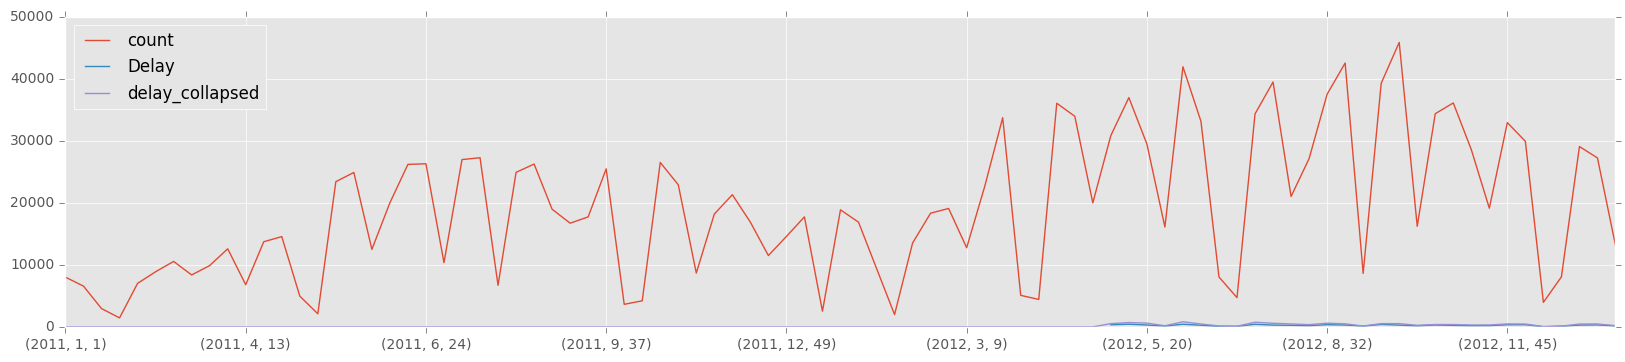

In [16]:
###We see high variability between weeks and seasons but it always increasing as riderships grows

trainByWeek.plot(figsize=(20,4))

plt.show()

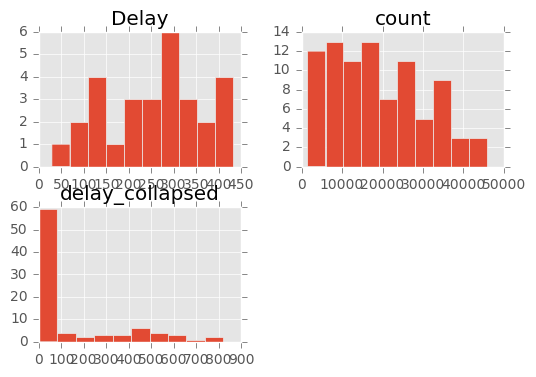

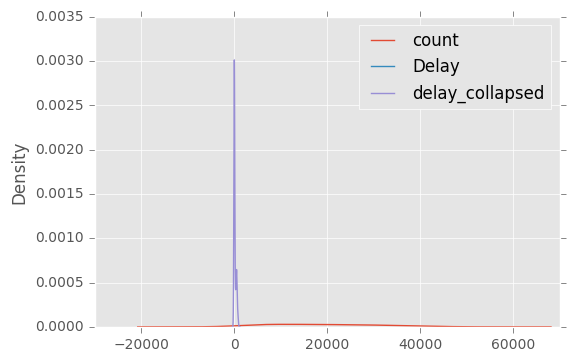

In [17]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data.
#The example below creates a histogram and density plot of the observations without any temporal structure.
trainByWeek.hist()
trainByWeek.plot(kind='kde')
plt.show()

#Some observations from the plots include:
    #The distribution is not Gaussian.
    #The shape has a long right tail and may suggest an exponential distribution. 
    #This lends more support to exploring some power transforms of the data prior to modeling.

In [18]:
########do adfuller to determine stationary of data
# import done in first cell
# from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

##create a list showing the difference between count in a given week in one year vs the previous year. 
##We use dictionaries to access the value from the previous year

date_dictionary={}
for index, row in trainByWeek.iterrows():
    count_value=row['count']
    
    date_dictionary.update({index: count_value})


##take the dictionary items from 2012 and get their corresponding 2011 values for a given week
yearly_difference=[]
for k, v in date_dictionary.items():
    if k[0]==2012:
        #print(k, v)
        this_year_value=v
        last_year=(k[0]-1, k[1], k[2])
        last_year_value=date_dictionary.get(last_year)
        try:
            difference=this_year_value - last_year_value
            
            yearly_difference.append(difference)
        except:
            pass
    else:
        pass
print(len(yearly_difference))        
        


#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(yearly_difference, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print("\n The results show that the test statistic value -5.04 is smaller than the critical value at 1% of -3.65. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).")
print("Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.")

41
Results of Dickey-Fuller Test:
Test Statistic                -7.728849e+00
p-value                        1.139623e-11
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+01
Critical Value (1%)           -3.605565e+00
Critical Value (5%)           -2.937069e+00
Critical Value (10%)          -2.606986e+00
dtype: float64

 The results show that the test statistic value -5.04 is smaller than the critical value at 1% of -3.65. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.


In [19]:
##The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.
##We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.
# import done in first cell
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf

#plt.figure()
#plt.subplot(211)
#plot_acf(trainByWeek, ax=plt.gca())
#plt.subplot(212)
#plot_pacf(trainByWeek, ax=plt.gca())
#plt.show()
#print("We see significant lag in the beginning part of the dataset and then it evens out")

In [20]:
# import done in first cell
# from statsmodels.tsa.arima_model import ARIMA

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


# walk-forward validation
history=[]    
for index, row in trainByWeek.iterrows():
   
    history.append(row['count'] )
devByWeek_list=[]
for index, row in devByWeek.iterrows():
    
    devByWeek_list.append(row['count'] )
            
predictions = list()
for i in range(len(devByWeek_list)):
	# difference data
	
	diff = difference(history)
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = devByWeek_list[i]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
# report performance
mse = mean_squared_error(devByWeek_list, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)




C:\Users\talt\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE: 3680.786


Since Time Series is meant for future prediction and we are not trying to achieve future prediction but instead filling in time gaps where the test data is held out out (ie last week of each month), we are imputing that value to be used in the test set when submitting the notebook to kaggle. The method for imputation is averaging the predicted counts for the 2 weeks prior and 2 weeks post the value we are imputing. This was accomplished in excel through the TS.csv that was generated. The excel file was then turned into Time_Series_formatted.csv after the transformations.

## Merge in Time Series Data

In [21]:
sortedFull["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in sortedFull["date"] ]
sortedFull.index=sortedFull['date1']


#sortedFull['year'], sortedFull['month'], sortedFull['week'] = sortedFull['date1'].apply(lambda x: x.year), fullWithWMATA['date1'].apply(lambda x: x.month), fullWithWMATA['date1'].apply(lambda x: x.week)
sortedFull['week'] = sortedFull['date1'].dt.week

print(list(sortedFull.columns.values))
Time_Series_formatted=pd.read_csv('~/datasets/bikeshare/Time_Series_formatted.csv')
sortedFull = sortedFull.drop(['date1'])

print(list(Time_Series_formatted.columns.values))

print(list(Time_Series_formatted.columns.values))




###For some reason the year/month/week function puts the beginning days of the year at week 52. This puts it back at week 1
sortedFull.ix[sortedFull.date.isin(['2011-01-01', '2011-01-02', '2011-01-03', '2012-01-01']), 'week']=1


fullWithAll = pd.merge(sortedFull,  Time_Series_formatted,  how='left', left_on=['year', 'week'], right_on=['year', 'week'])


##rename the variable we got from Time series to be more intuitive
fullWithAll.rename(columns={'predictions': 'predictedFromTS'}, inplace=True)
print(list(fullWithAll.columns.values))
fullWithAll.to_csv('~/datasets/bikeshare/merge_test.csv', sep=',')



['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'hour', 'Incident', 'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'year', 'month', 'day', 'yyyymmdd', 'dayNum', 'isSun', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'isLight', 'isDark', 'isTwilight', 'ceilingHeight', 'visibilityDistance', 'dewPoint', 'seaLevelPressure', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'prev_hour', 'prev_date', 'prev_month', 'date1', 'week']
['year', 'month', 'week', 'predictions']
['year', 'month', 'week', 'predictions']
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'hour', 'Incident', 'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'year', 'month_x', 'day', 'yyyymm

### Merge in Time Series to test set

In [22]:
sortedTest["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in sortedTest["date"] ]
sortedTest.index=sortedTest['date1']
print(list(sortedTest.columns.values))

#print(sortedTest)

#sortedTest['year'], sortedTest['month'], sortedTest['week'] = sortedTest['date1'].apply(lambda x: x.year), fullWithWMATA['date1'].apply(lambda x: x.month), fullWithWMATA['date1'].apply(lambda x: x.week)
sortedTest['week'] = sortedTest['date1'].dt.week
Time_Series_formatted=pd.read_csv('~/datasets/bikeshare/Time_Series_formatted.csv')
sortedTest = sortedTest.drop(['date1'])

print(list(Time_Series_formatted.columns.values))

print(list(Time_Series_formatted.columns.values))


###For some reason the year/month/week function puts the beginning days of the year at week 52. This puts it back at week 1
sortedTest.ix[sortedTest.date.isin(['2011-01-01', '2011-01-02', '2011-01-03', '2012-01-01']), 'week']=1


testWithAll = pd.merge(sortedTest,  Time_Series_formatted,  how='left', left_on=['year', 'week'], right_on=['year', 'week'])


##rename the variable we got from Time series to be more intuitive
testWithAll.rename(columns={'predictions': 'predictedFromTS'}, inplace=True)
print(list(testWithAll.columns.values))
testWithAll.to_csv('~/datasets/bikeshare/merge_test.csv', sep=',')



['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour', 'Incident', 'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'year', 'month', 'day', 'yyyymmdd', 'dayNum', 'isSun', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'isLight', 'isDark', 'isTwilight', 'ceilingHeight', 'visibilityDistance', 'dewPoint', 'seaLevelPressure', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'prev_hour', 'prev_date', 'prev_month', 'date1']
['year', 'month', 'week', 'predictions']
['year', 'month', 'week', 'predictions']
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour', 'Incident', 'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'year', 'month_x', 'day', 'yyyymmdd', 'dayNum', 'isSun', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', '

## Data Munging
Binarize and normalize the data

In [23]:
###TURN CATEGORICAL VARIABLES INTO DUMMY VARIABLES

#season: 1 = spring, 2 = summer, 3 = fall, 4 = winter 
fullWithAll['spring']=fullWithAll['season']==1 
#print("Spring vs. season")
#pd.crosstab(fullWithWMATAandTS.spring, fullWithWMATAandTS.season, margins=True)
fullWithAll['summer']=fullWithAll['season']==2
#print("Summer vs. season")
#pd.crosstab(fullWithWMATAandTS.summer, fullWithWMATAandTS.season, margins=True)
print("fall vs. season")
fullWithAll['fall']=fullWithAll['season']==3
pd.crosstab(fullWithAll.fall, fullWithAll.season, margins=True)
print(list(fullWithAll.columns.values))

# need to do this for the test data too

#season: 1 = spring, 2 = summer, 3 = fall, 4 = winter 
testWithAll['spring']=testWithAll['season']==1 
#print("Spring vs. season")
#pd.crosstab(fullWithWMATAandTS.spring, fullWithWMATAandTS.season, margins=True)
testWithAll['summer']=testWithAll['season']==2
#print("Summer vs. season")
#pd.crosstab(fullWithWMATAandTS.summer, fullWithWMATAandTS.season, margins=True)
print("fall vs. season")
testWithAll['fall']=testWithAll['season']==3
pd.crosstab(testWithAll.fall, testWithAll.season, margins=True)
print(list(testWithAll.columns.values))

print("values of holiday", fullWithAll.holiday.unique())
print("values of working day", fullWithAll.workingday.unique())

#Weather: 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
# 2: Mist/Cloudy, Mist/Broken clouds, Mist/Few clouds, Mist 
#3: Light Snow, Light Rain/Thunderstorm /Scattered clouds, Light Rain/Scattered clouds 
#4: Heavy Rain/Ice Pellets/Thunderstorm/Mist, Snow/Fog 
fullWithAll['clearOrPartlyCloudy']=fullWithAll['weather']==1
#print("clear vs. weather")
#pd.crosstab(fullWithWMATAandTS.clearOrPartlyCloudy, fullWithWMATAandTS.weather, margins=True)


fullWithAll['cloudOrMist']=fullWithAll['weather']==2
#print("cloudOrMist vs. weather")
#pd.crosstab(fullWithWMATAandTS.cloudOrMist, fullWithWMATAandTS.weather, margins=True)


fullWithAll['lightRainSnow']=fullWithAll['weather']==3
print("lightRainSnow vs. weather")
pd.crosstab(fullWithAll.lightRainSnow, fullWithAll.weather, margins=True)

testWithAll['clearOrPartlyCloudy']=testWithAll['weather']==1
testWithAll['cloudOrMist']=testWithAll['weather']==2
testWithAll['lightRainSnow']=testWithAll['weather']==3
print("lightRainSnow vs. weather")
pd.crosstab(testWithAll.lightRainSnow, testWithAll.weather, margins=True)

# need to munge the weather for the prior observation as well 
fullWithAll['prev_clearOrPartlyCloudy']=fullWithAll['prev_weather']==1
fullWithAll['prev_cloudOrMist']=fullWithAll['prev_weather']==2
fullWithAll['prev_lightRainSnow']=fullWithAll['prev_weather']==3
print("prev_lightRainSnow vs. prev_weather")
pd.crosstab(fullWithAll.prev_lightRainSnow, fullWithAll.prev_weather, margins=True)

testWithAll['prev_clearOrPartlyCloudy']=testWithAll['prev_weather']==1
testWithAll['prev_cloudOrMist']=testWithAll['prev_weather']==2
testWithAll['prev_lightRainSnow']=testWithAll['prev_weather']==3
print("prev_lightRainSnow vs. prev_weather")
pd.crosstab(testWithAll.prev_lightRainSnow, testWithAll.prev_weather, margins=True)

try: ##We drop in try/except in case we already ran the code and already dropped
    del fullWithAll['isDark']
    del fullWithAll['isSun']
    del testWithAll['isDark']
    del testWithAll['isSun']
except KeyError:
    pass
    
                               
#Rescale continous variables to (value - mean )/(max-min)
##save the mean max and min to a dictionary so we can apply these values to the test set. It is the best 
# practice to apply the standardization from the training set values and not the validation set
cols_to_norm = ['temp','atemp', 'humidity', 'windspeed', 'ceilingHeight', 'visibilityDistance',	'dewPoint' , 
                'seaLevelPressure', 'predictedFromTS', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 
                'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 
                'prev_windspeed', 'delay_collapsed', 'year', 'month_x', 'week', 'day', 'hour', 'dayNum']


mean_dict={}
max_dict={}
min_dict={}

for var in cols_to_norm:
    newName=var + '_std'
  
    meanValue=fullWithAll[var].mean()
    mean_dict.update({var:meanValue})
    maxValue=fullWithAll[var].max()
    max_dict.update({var:maxValue})
    minValue=fullWithAll[var].min()
    min_dict.update({var:minValue})
    avg = fullWithAll[var].mean()
    diff = maxValue - minValue
    fullWithAll[newName] = fullWithAll[var].apply(lambda x: (x-avg)/diff) 
   
print(mean_dict)
print(max_dict)
print(min_dict)

cols_to_norm_std =([ x + '_std' for x in cols_to_norm ])


for var in cols_to_norm_std:
    print("variable is:", var)
    print("minium value is:", np.min(fullWithAll[var]))
    print("maximum value is:", np.max(fullWithAll[var]))
    print("mean value is:", np.mean(fullWithAll[var]))
    print("\n" *2)   


fall vs. season
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'hour', 'Incident', 'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'year', 'month_x', 'day', 'yyyymmdd', 'dayNum', 'isSun', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'isLight', 'isDark', 'isTwilight', 'ceilingHeight', 'visibilityDistance', 'dewPoint', 'seaLevelPressure', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'prev_hour', 'prev_date', 'prev_month', 'date1', 'week', 'month_y', 'predictedFromTS', 'spring', 'summer', 'fall']
fall vs. season
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour', 'Incident', 'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'year', 'month_x', 'day', 'yyyymmdd', 'dayNum', 'isSun',

#### Apply normalization to test set

In [24]:
##We normalize variables in the test set based on the min/max/mean in the train/dev set.
print(list(testWithAll.columns.values))

for var in cols_to_norm:
    print(var)
    avg=mean_dict.get(var)
    maxValue=max_dict.get(var)
    minValue=min_dict.get(var)
    newName=var + '_std'
    diff = maxValue - minValue
    testWithAll[newName] = testWithAll[var].apply(lambda x: (x-avg)/diff) 
    
for var in cols_to_norm_std:
    print("variable is:", var)
    print("minium value is:", np.min(testWithAll[var]))
    print("maximum value is:", np.max(testWithAll[var]))
    print("mean value is:", np.mean(testWithAll[var]))
    print("\n" *2)   
    
    
    
    
    

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour', 'Incident', 'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'year', 'month_x', 'day', 'yyyymmdd', 'dayNum', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'isLight', 'isTwilight', 'ceilingHeight', 'visibilityDistance', 'dewPoint', 'seaLevelPressure', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'prev_hour', 'prev_date', 'prev_month', 'date1', 'week', 'month_y', 'predictedFromTS', 'spring', 'summer', 'fall', 'clearOrPartlyCloudy', 'cloudOrMist', 'lightRainSnow', 'prev_clearOrPartlyCloudy', 'prev_cloudOrMist', 'prev_lightRainSnow']
temp
atemp
humidity
windspeed
ceilingHeight
visibilityDistance
dewPoint
seaLevelPressure
predictedFromTS
prev_atemp
prev_ceilingHeight
prev_dewPoint
prev_humidity
prev_seaLevelPressure
prev_temp
prev_vi

# DataFrame Anchor

All analyses after this point need to start with the train and dev sets defined below from fullWithAll and TestWithAll should be used for prediction.  
These datasets are normalized and have all the features we engineered.  Since 
some of this code was developed in parallel and columns are dropped we will be making 
copies of datasets prior to each analysis to avoid inadvertent overlap
This is not efficient, but it will take too long to sort it out otherwise.

In [25]:
# full has counts, but otherwise the fields are the same
# this is just checking that we did not make a mistake
# full_cols=list(fullWithAll)
# del full_cols[3:6] # count fields -- so all cols line up for verification
for fvar,tvar in zip(list(fullWithAll), list(testWithAll)): print(fvar,tvar)

datetime datetime
season season
holiday holiday
workingday workingday
weather weather
temp temp
atemp atemp
humidity humidity
windspeed windspeed
casual date
registered hour
count Incident
date Line
hour Direction
Incident Cause
Line Delay
Direction delay_collapsed
Cause year
Delay month_x
delay_collapsed day
year yyyymmdd
month_x dayNum
day isMon
yyyymmdd isTues
dayNum isWeds
isMon isThurs
isTues isFri
isWeds isSat
isThurs isLight
isFri isTwilight
isSat ceilingHeight
isLight visibilityDistance
isTwilight dewPoint
ceilingHeight seaLevelPressure
visibilityDistance prev_atemp
dewPoint prev_ceilingHeight
seaLevelPressure prev_dewPoint
prev_atemp prev_humidity
prev_ceilingHeight prev_seaLevelPressure
prev_dewPoint prev_temp
prev_humidity prev_visibilityDistance
prev_seaLevelPressure prev_weather
prev_temp prev_windspeed
prev_visibilityDistance prev_hour
prev_weather prev_date
prev_windspeed prev_month
prev_hour date1
prev_date week
prev_month month_y
date1 predictedFromTS
week spring
month

Note above, that after the first several column names, they are off by three, because train and dev have 
count, registered, and causal.  Wasn't worth fixing b/c it was just a check on the code.

In [26]:
# Need to drop non-normalized/binarized features, as they are redundant

fullWithAll = fullWithAll.drop(['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'Incident', 
                                'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'ceilingHeight', 
                                'visibilityDistance', 'dewPoint', 'seaLevelPressure', 'prev_atemp', 
                                'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 
                                'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 
                                'prev_hour', 'prev_date', 'prev_month', 'predictedFromTS', 'prev_weather_std', 
                                'year', 'month_x', 'week', 'day', 'hour', 'dayNum'], 
                               axis=1)
testWithAll = testWithAll.drop(['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'Incident', 
                                'Line', 'Direction', 'Cause', 'Delay', 'delay_collapsed', 'ceilingHeight', 
                                'visibilityDistance', 'dewPoint', 'seaLevelPressure', 'prev_atemp', 
                                'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 
                                'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 
                                'prev_hour', 'prev_date', 'prev_month', 'predictedFromTS', 'prev_weather_std',
                                'year', 'month_x', 'week', 'day', 'hour', 'dayNum'], 
                               axis=1)

In [27]:
####recut the training and dev set with the new variables
# and standardize the names for all next sections
trainDF = fullWithAll[msk]
devDF=fullWithAll[~msk]
testDF=testWithAll
print("Full dataset shape:", fullWithAll.shape)
print("Train shape:", train.shape)
print("Dev shape:", dev.shape)
print("Test shape:", test.shape)

Full dataset shape: (10886, 51)
Train shape: (8715, 20)
Dev shape: (2171, 20)
Test shape: (6493, 11)


In [28]:
# Let's write out a file to read in later to save time
fullWithAll.to_csv('~/datasets/bikeshare/normalized_master_full2.csv', sep=',')
testWithAll.to_csv('~/datasets/bikeshare/normalized_master_test2.csv', sep=',')


## Random Forest

Below we implement a random forest algorithm after experimenting briefly with an SVR model and ridge regression. We took the algorithm to a 64 core cloud machine to run for several hours to find the optimal hyper parameters. However, the model did not perform the same when taken back to the local desktop despite having the same seed. It is probably due to OS differences. At any rate, we notice that there is a large difference in accuracy between the training and dev set. This is a sign of overfitting. We attempted to separate out the casual and registered variables and then add them together. We made attempts to curtail the overfitting by pruning the trees but were unsuccessful. According to kaggle, we could not get the RMSE below 1.01, which did not beat our baseline of 0.85. 

After normalizing some additional columns, given the results from before, it was not worth going back and rerunning this.

In [29]:
print(list(fullWithAll.columns.values))




other_vars=['season' , 'holiday', 'workingday', 'weather', 'year', 'delay_collapsed' ,  'isFri', 'isLight', 'isMon', 'isSat', 'isThurs', 'isTues', 'isTwilight', 'isWeds', 'month_x' ]




X_vars=cols_to_norm_std + other_vars

remove_vars=['prev_weather_std', 'season', 'weather' ,'year', 'delay_collapsed', 'month_x']
for j in remove_vars:
    X_vars.remove(j)


Y = fullWithAll['count'].values
X = fullWithAll[X_vars]

###Make sure we don't have any null values which would mess up our random forest

X.isnull().any()


['datetime', 'holiday', 'workingday', 'casual', 'registered', 'count', 'date', 'yyyymmdd', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'isLight', 'isTwilight', 'date1', 'month_y', 'spring', 'summer', 'fall', 'clearOrPartlyCloudy', 'cloudOrMist', 'lightRainSnow', 'prev_clearOrPartlyCloudy', 'prev_cloudOrMist', 'prev_lightRainSnow', 'temp_std', 'atemp_std', 'humidity_std', 'windspeed_std', 'ceilingHeight_std', 'visibilityDistance_std', 'dewPoint_std', 'seaLevelPressure_std', 'predictedFromTS_std', 'prev_atemp_std', 'prev_ceilingHeight_std', 'prev_dewPoint_std', 'prev_humidity_std', 'prev_seaLevelPressure_std', 'prev_temp_std', 'prev_visibilityDistance_std', 'prev_windspeed_std', 'delay_collapsed_std', 'year_std', 'month_x_std', 'week_std', 'day_std', 'hour_std', 'dayNum_std']


temp_std                       False
atemp_std                      False
humidity_std                   False
windspeed_std                  False
ceilingHeight_std              False
visibilityDistance_std         False
dewPoint_std                   False
seaLevelPressure_std           False
predictedFromTS_std            False
prev_atemp_std                 False
prev_ceilingHeight_std         False
prev_dewPoint_std              False
prev_humidity_std              False
prev_seaLevelPressure_std      False
prev_temp_std                  False
prev_visibilityDistance_std    False
prev_windspeed_std             False
delay_collapsed_std            False
year_std                       False
month_x_std                    False
week_std                       False
day_std                        False
hour_std                       False
dayNum_std                     False
holiday                        False
workingday                     False
isFri                          False
i

In [30]:

Y = fullWithAll['casual'].values
X = fullWithAll[X_vars].values

cv = cross_validation.ShuffleSplit(len(X), n_iter=3, test_size=0.2,
    random_state=401)

print ("SVR(kernel='rbf',C=10,gamma=.001)")
for train, dev in cv:
    
    svc = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))

print ("Ridge"  )  
for train, dev in cv:    
    svc = linear_model.Ridge().fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
print ("Random Forest(n_estimators = 100)"   ) 
for train, dev in cv:    
    svc = RandomForestRegressor(n_estimators = 100).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    


SVR(kernel='rbf',C=10,gamma=.001)
train score: 0.248, dev score: 0.258

train score: 0.245, dev score: 0.236

train score: 0.242, dev score: 0.279

Ridge
train score: 0.552, dev score: 0.550

train score: 0.551, dev score: 0.555

train score: 0.554, dev score: 0.537

Random Forest(n_estimators = 100)
train score: 0.989, dev score: 0.926

train score: 0.989, dev score: 0.918

train score: 0.990, dev score: 0.918



In [31]:
###Random forest was the best so let's tune that




#####We executed the following code on a 64 core Virtual Server to train the best random forest outcome. We leave it here but commented out to show 
##what we did. 
# Set the parameters by cross-validation

#Commented out code block:
#################################################################################################################################
#
#tuned_parameters = {'n_estimators': [ 50, 100, 150, 200,  500, 750, 1000], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100], 'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]}
#
#
#clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10,  n_jobs=-1, verbose=1)
#clf.fit(X[train], Y[train])
#
#clf.fit(X, Y)
#print("casual")
#print (clf.best_estimator_)
########################################################################################################3


###Results of the gridsearch are below from 13,700 fits in 190 minutes on 64 cores.

#RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
          # max_features='auto', max_leaf_nodes=None,
          # min_impurity_decrease=0.0, min_impurity_split=None,
          # min_samples_leaf=1, min_samples_split=15,
          # min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
         #  oob_score=False, random_state=None, verbose=0, warm_start=False)


In [32]:

Y = fullWithAll['registered'].values
X = fullWithAll[X_vars].values

cv = cross_validation.ShuffleSplit(len(X), n_iter=3, test_size=0.2,
    random_state=401)

print ("SVR(kernel='rbf',C=10,gamma=.001)")
for train, dev in cv:
    
    svc = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))

print ("Ridge"  )  
for train, dev in cv:    
    svc = linear_model.Ridge().fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
print ("Random Forest(n_estimators = 100)"   ) 
for train, dev in cv:    
    svc = RandomForestRegressor(n_estimators = 100).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    


SVR(kernel='rbf',C=10,gamma=.001)
train score: 0.127, dev score: 0.150

train score: 0.124, dev score: 0.119

train score: 0.121, dev score: 0.142

Ridge
train score: 0.489, dev score: 0.491

train score: 0.484, dev score: 0.510

train score: 0.492, dev score: 0.476

Random Forest(n_estimators = 100)
train score: 0.992, dev score: 0.949

train score: 0.992, dev score: 0.941

train score: 0.993, dev score: 0.921



In [33]:





#####We executed the following code on a 64 core Virtual Server to train the best random forest outcome. We leave it here but commented out to show 
##what we did. 
# Set the parameters by cross-validation

#Commented out code block:
#################################################################################################################################
#
#tuned_parameters = {'n_estimators': [ 50, 100, 150, 200,  500, 750, 1000], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100], 'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]}
#
#
#clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10,  n_jobs=-1, verbose=1)
#clf.fit(X[train], Y[train])
#
#clf.fit(X, Y)
#print("registered")
#print (clf.best_estimator_)
########################################################################################################3


###Results of the gridsearch are below from 13,700 fits in 211 minutes on 64 cores.

#RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           #max_features='auto', max_leaf_nodes=None,
           #min_impurity_decrease=0.0, min_impurity_split=None,
           #min_samples_leaf=1, min_samples_split=10,
           #min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           #oob_score=False, random_state=None, verbose=0, warm_start=False)


In [34]:
####Finalize random forest on casual



cv = cross_validation.ShuffleSplit(len(X), n_iter=4, test_size=0.2,
    random_state=401)





Y = fullWithAll['casual'].values





testSetForest= testWithAll[X_vars].values





for train, dev in cv:
    

    svc = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           
           min_samples_leaf=1, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False).fit(X[train], Y[train])
    
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
    
    



    
preds_casual=svc.predict(testSetForest)    


train score: 0.807, dev score: 0.795

train score: 0.795, dev score: 0.754

train score: 0.811, dev score: 0.800

train score: 0.808, dev score: 0.817



In [35]:
####Finalize random forest on registered



cv = cross_validation.ShuffleSplit(len(X), n_iter=2, test_size=0.2,
    random_state=401)





Y = fullWithAll['registered'].values





testSetForest= testWithAll[X_vars].values





for train, dev in cv:
    

    svc = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False).fit(X[train], Y[train])
    svc=RandomForestRegressor(n_estimators = 100).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
    
    



    
preds_registered=svc.predict(testSetForest)    





train score: 0.992, dev score: 0.950

train score: 0.992, dev score: 0.941



In [36]:
# Let's wreite out a Kaggle submission file.

datetime=test['datetime']

print(type(datetime))

test2 = list(zip(datetime,preds_casual, preds_registered))
zipped_list = test2[:]
zipped_list_2 = list(test2)



submission = pd.DataFrame(zipped_list_2)
submission.columns = ['datetime', 'casual', 'registered']

submission['count'] = submission['casual'] + submission['registered']

submission=submission.drop(['casual', 'registered'], axis=1)

submission = submission.set_index('datetime')
submission['count'] = submission['count'].apply(lambda x: round(x,0))
submission['count']
print(submission)
#print(submission)
submission.to_csv('~/datasets/bikeshare/random_forest.csv', sep=',')

<class 'pandas.core.series.Series'>
                     count
datetime                  
2011-01-20 00:00:00   15.0
2011-01-20 01:00:00    8.0
2011-01-20 02:00:00    5.0
2011-01-20 03:00:00    4.0
2011-01-20 04:00:00    4.0
2011-01-20 05:00:00    7.0
2011-01-20 06:00:00   32.0
2011-01-20 07:00:00   87.0
2011-01-20 08:00:00  202.0
2011-01-20 09:00:00  120.0
2011-01-20 10:00:00   61.0
2011-01-20 11:00:00   63.0
2011-01-20 12:00:00   79.0
2011-01-20 13:00:00   74.0
2011-01-20 14:00:00   75.0
2011-01-20 15:00:00   78.0
2011-01-20 16:00:00   94.0
2011-01-20 17:00:00  190.0
2011-01-20 18:00:00  178.0
2011-01-20 19:00:00  110.0
2011-01-20 20:00:00   77.0
2011-01-20 21:00:00   54.0
2011-01-20 22:00:00   41.0
2011-01-20 23:00:00   30.0
2011-01-21 00:00:00   20.0
2011-01-21 01:00:00    9.0
2011-01-21 02:00:00    5.0
2011-01-21 03:00:00    4.0
2011-01-21 04:00:00    4.0
2011-01-21 05:00:00    7.0
...                    ...
2012-12-30 18:00:00  258.0
2012-12-30 19:00:00  228.0
2012-12-30 20:00:00

# Linear Regression Analysis (Lasso) to determine important features

In [29]:
# Now lets do Linear Regression using L1 to identify important features

from itertools import compress

datetime = test['datetime']

# make a copy of the train and dev data so we don't harm the original
train_data=trainDF.copy()
print(type(trainDF))
dev_data=devDF.copy()
test_data=testDF.copy()

# Split train and dev into training/dev data and training/dev labels

train_labels = train_data['count'].values
train_casual_labels = train_data['casual'].values
train_registered_labels = train_data['registered'].values
train_data = train_data.drop(['date', 'date1', 'datetime', 'count', 'casual', 'registered', 'month_y', 'yyyymmdd'], axis = 1)
dev_labels = dev_data['count'].values
dev_casual_labels = dev_data['casual'].values
dev_registered_labels = dev_data['registered'].values
dev_data = dev_data.drop(['date', 'date1', 'datetime', 'count', 'casual', 'registered', 'month_y', 'yyyymmdd'], axis = 1)
test_data = test_data.drop(['date', 'date1', 'datetime', 'month_y', 'yyyymmdd'], axis = 1)
train_data_titles = list(train_data)

print(list(train_data))

# pick a reasonable alpha
# We ran through .01 through 100 and .1 was the best.  Since we are primarily doing this to 
# look at feature selection, taking the best alpha and moving ahead seemed like a good plan
# none of the RMSLEs beat our baseline submission

alpha_list = [0.1]
    
for a in alpha_list:
    clf = linear_model.Lasso(alpha=a)
    clf.fit(train_data, train_labels)
    print('Alpha:', a)
    print(clf.coef_.shape)
#    print('Coefficient of each feature:', clf.coef_)
    non_zero_mask = [x!=0 for x in list(clf.coef_.ravel())]
    zero_mask = [x==0 for x in list(clf.coef_.ravel())]
#     print(non_zero_mask)
    usable_features = list(compress(train_data_titles, non_zero_mask))
    usable_feature_coef = list(compress(clf.coef_, non_zero_mask))
    print(len(usable_features))
    sort_index=np.argsort([abs(number) for number in usable_feature_coef])
    print(sort_index)
    for i in range(len(usable_features)):
        print(i, usable_features[sort_index[i]], usable_feature_coef[sort_index[i]])
    features_to_drop = list(compress(train_data_titles, zero_mask))
    print('\nNon-zero features: ',usable_features)
    print('\nUseless_features: ', features_to_drop)
    print('Training accuracy:', clf.score(train_data, train_labels))
    print('Test accuracy:', clf.score(dev_data, dev_labels))
    print('')    


<class 'pandas.core.frame.DataFrame'>
['holiday', 'workingday', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'isLight', 'isTwilight', 'spring', 'summer', 'fall', 'clearOrPartlyCloudy', 'cloudOrMist', 'lightRainSnow', 'prev_clearOrPartlyCloudy', 'prev_cloudOrMist', 'prev_lightRainSnow', 'temp_std', 'atemp_std', 'humidity_std', 'windspeed_std', 'ceilingHeight_std', 'visibilityDistance_std', 'dewPoint_std', 'seaLevelPressure_std', 'predictedFromTS_std', 'prev_atemp_std', 'prev_ceilingHeight_std', 'prev_dewPoint_std', 'prev_humidity_std', 'prev_seaLevelPressure_std', 'prev_temp_std', 'prev_visibilityDistance_std', 'prev_windspeed_std', 'delay_collapsed_std', 'year_std', 'month_x_std', 'week_std', 'day_std', 'hour_std', 'dayNum_std']
Alpha: 0.1
(43,)
29
[20  1 14  2  9 15 28  0 13  4 26 16  3 11 18  5 12  8 10 25 24  7 23 17 19
 21  6 27 22]
0 prev_seaLevelPressure_std -0.352322536991
1 isMon -0.63200807753
2 ceilingHeight_std -0.667297719739
3 isWeds 2.13140034998
4 cloudOrMis

# Analysis of feature extraction effort
These results show that our belief that the previous hour's data was more important than the current hour for predicting behavior proved very true, as for all weather data except windspeed, the prior weather was more important.  Additionally, delays and timeseries information is also very predictive.  Dewpoint and visibility do not seem important, and some of the time values, which are redundant are also not important.

In [30]:
# Need to drop useless features

train_data = train_data.drop(['holiday', 'isTues', 'spring', 'clearOrPartlyCloudy', 
                                'prev_cloudOrMist', 'temp_std', 'atemp_std', 'humidity_std', 
                                'visibilityDistance_std', 'dewPoint_std', 'prev_dewPoint_std', 
                                'prev_visibilityDistance_std', 'prev_windspeed_std'], 
                               axis=1)
dev_data = dev_data.drop(['holiday', 'isTues', 'spring', 'clearOrPartlyCloudy', 
                                'prev_cloudOrMist', 'temp_std', 'atemp_std', 'humidity_std', 
                                'visibilityDistance_std', 'dewPoint_std', 'prev_dewPoint_std', 
                                'prev_visibilityDistance_std', 'prev_windspeed_std'], 
                               axis=1)
test_data = test_data.drop(['holiday', 'isTues', 'spring', 'clearOrPartlyCloudy', 
                                'prev_cloudOrMist', 'temp_std', 'atemp_std', 'humidity_std', 
                                'visibilityDistance_std', 'dewPoint_std', 'prev_dewPoint_std', 
                                'prev_visibilityDistance_std', 'prev_windspeed_std'], 
                               axis=1)



In [31]:
train_data.to_csv('~/datasets/bikeshare/train_data.csv', sep=',')
dev_data.to_csv('~/datasets/bikeshare/dev_data.csv', sep=',')

# Linear Regression Analyses

In [32]:
# I commented this first block out, since it's being weird among our different machines...

# Stats Model OLS
#ordin = sm.OLS(train_labels, train_data)
#ordin2 = ordin.fit()
#print(ordin2.summary())



# Linear Regression:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(train_data, train_labels)
coefficients = lin_reg.coef_

lin_pred = lin_reg.predict(dev_data)
  
print()
print("===========================================")   
print('Linear Regression Error - RMSLE:', rmsle(dev_labels, lin_pred))
print("===========================================") 

# Let's try Lasso:
alpha = [0.1, 1, 2, 3, 4, 10, 30]
best_alpha = 0
best_rmsle = 100

for i in range(7):
    lasso_reg = linear_model.Lasso(alpha = alpha[i])
    lasso_reg.fit(train_data, train_labels)
    lasso_pred = lasso_reg.predict(dev_data)
    error = rmsle(dev_labels, lasso_pred)

    if error < best_rmsle:
        best_rmsle = error
        best_alpha = alpha[i]

print('Lasso Regression - Best alpha is:', best_alpha, 'with an RMSLE of:', best_rmsle)
print("===========================================") 

lasso_reg = linear_model.Lasso(alpha = 0.1)
lasso_reg.fit(train_data, train_labels)
lasso_pred = lasso_reg.predict(test_data)

submission = pd.DataFrame({
        "datetime": datetime,
        "count": [max(0, x) for x in lasso_pred]
    })
submission = submission.set_index('datetime')
submission.to_csv('~/datasets/bikeshare/lasso_reg_result.csv', sep=',')


Linear Regression Error - RMSLE: 1.20903904946
Lasso Regression - Best alpha is: 4 with an RMSLE of: 1.13485788064


This is very disappointing! Everything we try seems to do worse than our simple hourly averages!!

In [33]:
variance = train_data.var()
print(variance)

# We can see the variables with each of their variances.

workingday                   0.217136
isMon                        0.120983
isWeds                       0.120818
isThurs                      0.124016
isFri                        0.120488
isSat                        0.124667
isLight                      0.249914
isTwilight                   0.112437
summer                       0.188678
fall                         0.189641
cloudOrMist                  0.192372
lightRainSnow                0.071850
prev_clearOrPartlyCloudy     0.223757
prev_lightRainSnow           0.073589
windspeed_std                0.020456
ceilingHeight_std            0.127844
seaLevelPressure_std         0.075256
predictedFromTS_std          0.031733
prev_atemp_std               0.035881
prev_ceilingHeight_std       0.127541
prev_humidity_std            0.036668
prev_seaLevelPressure_std    0.075922
prev_temp_std                0.037527
delay_collapsed_std          0.003860
year_std                     0.250023
month_x_std                  0.097437
week_std    

In [34]:
# Since Linear and Lasso Regressions yielded the best RMSLE, let's use these to
# try separating casual and registered riders into two models,
# generate a regression on each, then combine the results.
# Casual and Registered Riders are independent of each other, and the variables would affect these riders separately.
# Let's see if a regression using two different models (casual and registered) improves our error.

train_data_titles = list(train_data.columns.values)

# Linear Regression:
casual_lin_reg = linear_model.LinearRegression()
casual_lin_reg.fit(train_data, train_casual_labels)
casual_coefficients = casual_lin_reg.coef_
casual_lin_pred = casual_lin_reg.predict(dev_data)

registered_lin_reg = linear_model.LinearRegression()
registered_lin_reg.fit(train_data, train_registered_labels)
registered_coefficients = registered_lin_reg.coef_
registered_lin_pred = registered_lin_reg.predict(dev_data)

total_count = [casual_lin_pred[i]+registered_lin_pred[i] for i in range(len(registered_lin_pred))]

print()
print("===========================================")   
print('Linear Regression Error - RMSLE:', rmsle(dev_labels, total_count))
print("===========================================") 

# Perform predictions on the whole dataset
# Linear Regression:
casual_test_pred = casual_lin_reg.predict(test_data)
registered_test_pred = registered_lin_reg.predict(test_data)

total_test_count = [casual_test_pred[i]+registered_test_pred[i] for i in range(len(registered_test_pred))]

submission = pd.DataFrame({
        "datetime": datetime,
        "count": [max(0, x) for x in total_test_count]
    })
submission = submission.set_index('datetime')
submission.to_csv('~/datasets/bikeshare/lin_reg_combined_result.csv', sep=',')




Linear Regression Error - RMSLE: 1.20903904946


In [35]:
# Let's remove some variables that do not have a statistical significance:
# Keep these variables['hour', 'season', 'temp', 'weather', 'workingday', 'year']

# Linear Regression:
try_cols=['hour_std', 'summer', 'fall',  'prev_clearOrPartlyCloudy',
          'prev_lightRainSnow', 'workingday', 'year_std']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(train_data[try_cols], train_labels)
coefficients = lin_reg.coef_

lin_pred = lin_reg.predict(dev_data[try_cols])
  
print()
print("===========================================")   
print('Combined Ridership, Linear Regression Error - RMSLE:', rmsle(dev_labels, lin_pred))
print("===========================================") 

# Linear regression for the casual and registered riders separately, then combine the predictions
casual_lin_reg = linear_model.LinearRegression()
casual_lin_reg.fit(train_data[try_cols], train_casual_labels)
casual_coefficients = casual_lin_reg.coef_
casual_lin_pred = casual_lin_reg.predict(dev_data[try_cols])

registered_lin_reg = linear_model.LinearRegression()
registered_lin_reg.fit(train_data[try_cols], train_registered_labels)
registered_coefficients = registered_lin_reg.coef_
registered_lin_pred = registered_lin_reg.predict(dev_data[try_cols])

total_count = [casual_lin_pred[i]+registered_lin_pred[i] for i in range(len(registered_lin_pred))]

print()
print("===========================================")   
print('Separated Ridership, Linear Regression Error - RMSLE:', rmsle(dev_labels, total_count))
print("===========================================") 



Combined Ridership, Linear Regression Error - RMSLE: 1.30979984882

Separated Ridership, Linear Regression Error - RMSLE: 1.30979984882


# DecisionTreeRegressor - pick important variables, Analyze and Predict Data

In [36]:
def dtr(DTVars, splits, max_features, max_deps):
    #####################################################
    # We want to try Decision Tree as it is a non-linear model
    # that might also help us pick good features
    #######################################################

    all_vars = DTVars==[]
    print(all_vars)
    
    # It will run on all available variables, or a list can be supplied
    if all_vars:
        myTrain_data=train_data
        myDev_data=dev_data
        myTest_data=test_data
    else:
        myTrain_data=train_data[DTVars]
        myDev_data=dev_data[DTVars]
        myTest_data=test_data[DTVars]

    # initialize our vars to keep tack of our best hyperparameters
    bestHP=[]
    lowest_rmsle=100
    results=[]
 
    # print header for accuracy data
    print("\nRMSLE OF DECISION TREE PREDICTIONS ON DEVELOPMENT SET")
    if all_vars:
        print('For all features')
    else:
        print('For the following features: ', DTVars)
    print("\n===========================================")   

    # loop over all hyperparameters
    for split in splits:
        for md in max_deps:
            for mf in max_features:
                if mf > len(Features):
                    mf=len(Features)
                # run a quick test to make sure we have this basically working
                DTCasual = DecisionTreeRegressor(splitter=split, max_depth=md, max_features=mf)
                DTRegistered = DecisionTreeRegressor(splitter=split, max_depth=md, max_features=mf)
                DTTotal = DecisionTreeRegressor(splitter=split, max_depth=md, max_features=mf)

                DTCasual.fit(myTrain_data, train_casual_labels)
                DTRegistered.fit(myTrain_data, train_registered_labels)
                DTTotal.fit(myTrain_data, train_labels)

                predict_casual_labels = DTCasual.predict(myDev_data)
                predict_registered_labels =DTRegistered.predict(myDev_data)
                predict_total_labels =DTTotal.predict(myDev_data)

                print(split, 'max depth: ', md, 'max features: ', mf,
                      'DecisionTree Casual Regression Error - RMSLE:', rmsle(dev_casual_labels, 
                                                                             predict_casual_labels))
                print(split, 'max depth: ', md, 'max features: ', mf,
                      'DecisionTree Registered Regression Error - RMSLE:', rmsle(dev_registered_labels, 
                                                                             predict_registered_labels))
                current_rmsle=rmsle(dev_labels, predict_total_labels)
                print(split, 'max depth: ', md, 'max features: ', mf,
                      'DecisionTree Total Regression Error - RMSLE:',current_rmsle )
                print("===========================================\n") 

                results.append([split, md, mf, current_rmsle])
                if lowest_rmsle > current_rmsle:
                    lowest_rmsle = current_rmsle
                    bestHP=[DTVars, split, md, mf, current_rmsle]
                    
    print("\n===========================================")   
    print('Best Hyperparameters are: ', bestHP)
    print("===========================================\n") 
    
    # Now lets generate a Kaggle submission based on the best
    DTTotal = DecisionTreeRegressor(splitter=split, max_depth=md, max_features=mf)
    DTTotal.fit(myTrain_data, train_labels)
    predict_total_labels =DTTotal.predict(myTest_data)   
    predict_train_labels =DTTotal.predict(myTest_data)   

    DTTest2 = list(zip(datetime,predict_total_labels))
    zipped_list = DTTest2[:]
    zipped_list_2 = list(DTTest2)

    DTTrain2 = list(zip(datetime,predict_train_labels, train_labels))
    zipped_train_list = DTTrain2[:]
    zipped_train_list_2 = list(DTTrain2)

    submission = pd.DataFrame(zipped_list_2)
    submission.columns = ['datetime', 'count']

    submission = submission.set_index('datetime')
    submission['count'] = submission['count'].apply(lambda x: round(x,0))
    submission['count']

    sub_train = pd.DataFrame(zipped_train_list_2)
    sub_train.columns = ['datetime', 'predicted_train', 'count']

    sub_train = sub_train.set_index('datetime')
    sub_train['predicted_train'] = sub_train['predicted_train'].apply(lambda x: round(x,0))
    sub_train['predicted_train']
    
    if all_vars:
        submission.to_csv('~/datasets/bikeshare/DTFullVars.csv', sep=',')
        submission.to_csv('~/datasets/bikeshare/DTFullVarsTrain.csv', sep=',')
    else:
        submission.to_csv('~/datasets/bikeshare/DTSelectedVars.csv', sep=',')
        submission.to_csv('~/datasets/bikeshare/DTSelectedVarsTrain.csv', sep=',')

    return results

# Set hyperparameter options and run

Features=['hour_std', 'summer', 'fall', 'prev_temp_std', 'cloudOrMist', 'lightRainSnow', 
          'prev_clearOrPartlyCloudy', 'workingday', 'year_std','prev_humidity_std','isLight',
          'delay_collapsed_std']

split_methods=['best', 'random']
max_feats=[5,10,15,20]
max_deps=[5, 10, 15, 20, 25, 30]
feats=[]

allVarsResults= dtr(feats, split_methods, max_feats, max_deps)
someVarsResults = dtr(Features, split_methods, max_feats, max_deps)


True

RMSLE OF DECISION TREE PREDICTIONS ON DEVELOPMENT SET
For all features

best max depth:  5 max features:  5 DecisionTree Casual Regression Error - RMSLE: 1.04750978968
best max depth:  5 max features:  5 DecisionTree Registered Regression Error - RMSLE: 1.2383423734
best max depth:  5 max features:  5 DecisionTree Total Regression Error - RMSLE: 1.09945391445

best max depth:  5 max features:  10 DecisionTree Casual Regression Error - RMSLE: 0.89511551104
best max depth:  5 max features:  10 DecisionTree Registered Regression Error - RMSLE: 1.15408417484
best max depth:  5 max features:  10 DecisionTree Total Regression Error - RMSLE: 0.821585036965

best max depth:  5 max features:  12 DecisionTree Casual Regression Error - RMSLE: 0.883263977356
best max depth:  5 max features:  12 DecisionTree Registered Regression Error - RMSLE: 0.853653309288
best max depth:  5 max features:  12 DecisionTree Total Regression Error - RMSLE: 0.7193656001

best max depth:  5 max features:  12 De

C:\Users\talt\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


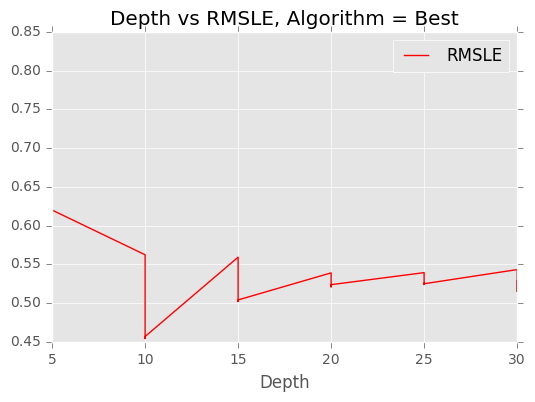

In [116]:
# Plot the RMSLE

DT_res_rmsle=np.array(someVarsResults)
DTdf = pd.DataFrame(data = DT_res_rmsle[:,:], columns=["Split", "Depth","Features", "RMSLE"])
DTdf[['Depth', 'Features', 'RMSLE']] = DTdf[['Depth', 'Features', 'RMSLE']].apply(pd.to_numeric)

bestDF = DTdf.loc[DTdf['Split'] == 'best']
bestDF[['Depth', 'Features', 'RMSLE']] = bestDF[['Depth', 'Features', 'RMSLE']].apply(pd.to_numeric)
bestFeatures = bestDF.groupby('Features')['RMSLE'].max()
bestDF.plot(x='Depth', y='RMSLE', color = 'red', title='Depth vs RMSLE, Algorithm = Best')

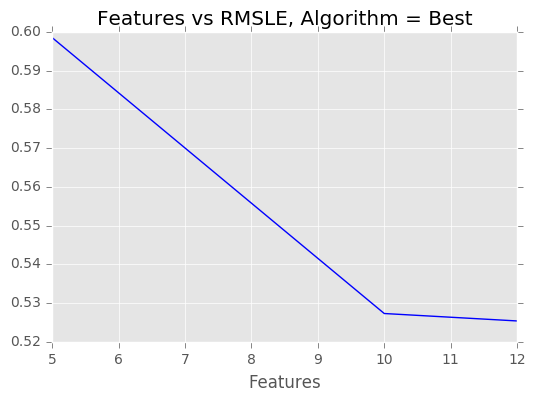

In [113]:
bestFeatures.plot(x='Features', y='RMSLE', color = 'blue', title='Features vs RMSLE, Algorithm = Best')

C:\Users\talt\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


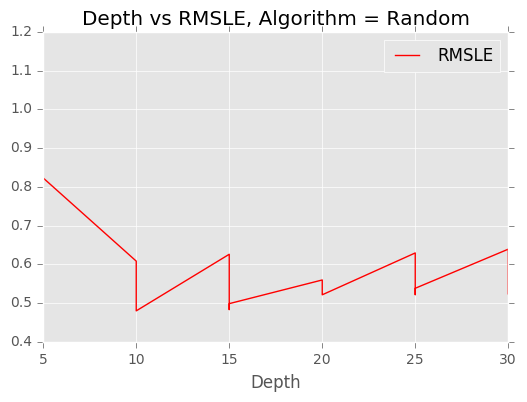

In [117]:
randomDF = DTdf.loc[DTdf['Split'] == 'random']
randomDF[['Depth', 'Features', 'RMSLE']] = randomDF[['Depth', 'Features', 'RMSLE']].apply(pd.to_numeric)

randomDF.plot(x='Depth', y='RMSLE', color = 'red', title='Depth vs RMSLE, Algorithm = Random')

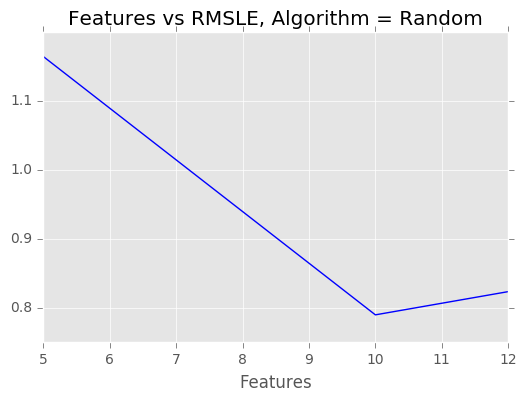

In [120]:
randomFeatures = randomDF.groupby('Features')['RMSLE'].max()
randomFeatures.plot(x='Features', y='RMSLE', color = 'blue', title='Features vs RMSLE, Algorithm = Random')

This looked very promising, but when we submitted to Kaggle, our score was .58733, more thank our KNN below, so there is some overfitting going on.  We then tried a subset of the variables, but that wasn't very good either, though both beat our baseline submission by more than .3 points, and 600 places in the rankings.

We did a hyperparameter search, as well over the full set of features as well as over a restricted set of features.

# KNN Regression - Analyze and Predict Data

In [46]:
#####################################################
# We want to try KNN as it is a non-linear model
#
#######################################################

def myKNN(KNNFeatures, Ks, algs):

    all_vars = KNNFeatures==[]
        
    # It will run on all available variables, or a list can be supplied
    if all_vars:
        myTrain_data=train_data
        myDev_data=dev_data
        myTest_data=test_data
    else:
        myTrain_data=train_data[KNNFeatures]
        myDev_data=dev_data[KNNFeatures]
        myTest_data=test_data[KNNFeatures]

    # initialize our vars to keep tack of our best hyperparameters
    bestHP=[]
    lowest_rmsle=100
    KNNResults=[]

    # print header for rmsle data
    print("RMSLE OF KNN PREDICTIONS ON DEVELOPMENT SET")
    if all_vars:
        print('For all features')
    else:
        print('For the following features: ', KNNFeatures)
    print("\n===========================================")   
    
    for k in ks:
        for alg in algs:
            
            # create a regressor for each dependent variable
            KNNCasual = KNeighborsRegressor(n_neighbors=k, algorithm=alg)
            KNNRegistered = KNeighborsRegressor(n_neighbors=k, algorithm=alg)
            KNNTotal = KNeighborsRegressor(n_neighbors=k, algorithm=alg)

            # fit the models
            KNNCasual.fit(myTrain_data, train_casual_labels)
            KNNRegistered.fit(myTrain_data, train_registered_labels)
            KNNTotal.fit(myTrain_data, train_labels)

            # predict the results
            predict_casual_labels = KNNCasual.predict(myDev_data)
            predict_registered_labels =KNNRegistered.predict(myDev_data)
            predict_total_labels =KNNTotal.predict(myDev_data)

            print(k, alg,'KNN Casual Regression Error - RMSLE:', rmsle(dev_casual_labels, predict_casual_labels))
            print(k,alg,'KNN Registered Regression Error - RMSLE:', rmsle(dev_registered_labels, 
                                                                          predict_registered_labels))
            current_rmsle=rmsle(dev_labels, predict_total_labels)
            print(k,alg,'KNN Total Regression Error - RMSLE:', current_rmsle)
            print("===========================================\n")   

            KNNResults.append([k,alg,current_rmsle])
            if lowest_rmsle > current_rmsle:
                lowest_rmsle = current_rmsle
                bestHP=[KNNFeatures, k, alg, current_rmsle]

    # Now lets generate a Kaggle submission
    predict_casual_labels = KNNCasual.predict(myTest_data)
    predict_registered_labels =KNNRegistered.predict(myTest_data)
    predict_total_labels =KNNTotal.predict(myTest_data)  
    predict_train_labels =KNNTotal.predict(myTrain_data)

    print("\n===========================================")   
    print('Best Hyperparameters are: ', bestHP)
    print("===========================================\n") 
    
    # Now lets generate a Kaggle submission based on the best
    KNNTotal = KNeighborsRegressor(n_neighbors=k, algorithm=alg)
    KNNTotal.fit(myTrain_data, train_labels)
    predict_total_labels =KNNTotal.predict(myTest_data)
    predict_train_labels=KNNTotal.predict(myTrain_data)

    KNNTest2 = list(zip(datetime,predict_total_labels))
    zipped_list = KNNTest2[:]
    zipped_list_2 = list(KNNTest2)

    KNNTrain2 = list(zip(datetime,predict_train_labels,train_labels))
    zipped_train_list = KNNTrain2[:]
    zipped_train_list_2 = list(KNNTrain2)

    submission = pd.DataFrame(zipped_list_2)
    submission.columns = ['datetime', 'count']

    sub_train_data = pd.DataFrame(zipped_train_list_2)
    sub_train_data.columns = ['datetime', 'KNNTrained','count']

    submission = submission.set_index('datetime')
    submission['count'] = submission['count'].apply(lambda x: round(x,0))
    submission['count']

    sub_train_data = sub_train_data.set_index('datetime')
    sub_train_data['KNNTrained'] = sub_train_data['KNNTrained'].apply(lambda x: round(x,0))
    sub_train_data['KNNTrained']

    if all_vars:
        submission.to_csv('~/datasets/bikeshare/KNNFullVars.csv', sep=',')
        sub_train_data.to_csv('~/datasets/bikeshare/KNNFullVarsTrain.csv', sep=',')
    else:
        submission.to_csv('~/datasets/bikeshare/KNNSelectedVars.csv', sep=',')
        sub_train_data.to_csv('~/datasets/bikeshare/KNNSelectedVarsTrain.csv', sep=',')

    print(KNNResults[:5])
    return KNNResults

# Set hyperparameter options and run

Features=['hour_std', 'summer', 'fall', 'prev_temp_std', 'cloudOrMist', 'lightRainSnow', 
          'prev_clearOrPartlyCloudy', 'workingday', 'year_std']
feats=[]
ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
algs =['auto', 'ball_tree', 'kd_tree', 'brute' ]

all_var_KNNResults = myKNN(feats, ks, algs)
# subset_var_KNNResults = myKNN(Features, ks, algs)


RMSLE OF KNN PREDICTIONS ON DEVELOPMENT SET
For all features

1 auto KNN Casual Regression Error - RMSLE: 0.963062923857
1 auto KNN Registered Regression Error - RMSLE: 0.971101457976
1 auto KNN Total Regression Error - RMSLE: 0.956685281773

1 ball_tree KNN Casual Regression Error - RMSLE: 0.963062923857
1 ball_tree KNN Registered Regression Error - RMSLE: 0.971101457976
1 ball_tree KNN Total Regression Error - RMSLE: 0.956685281773

1 kd_tree KNN Casual Regression Error - RMSLE: 0.963062923857
1 kd_tree KNN Registered Regression Error - RMSLE: 0.971101457976
1 kd_tree KNN Total Regression Error - RMSLE: 0.956685281773

1 brute KNN Casual Regression Error - RMSLE: 0.963062923857
1 brute KNN Registered Regression Error - RMSLE: 0.971101457976
1 brute KNN Total Regression Error - RMSLE: 0.956685281773

2 auto KNN Casual Regression Error - RMSLE: 0.877151483693
2 auto KNN Registered Regression Error - RMSLE: 0.9048462145
2 auto KNN Total Regression Error - RMSLE: 0.895241683727

2 ball_t

C:\Users\talt\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


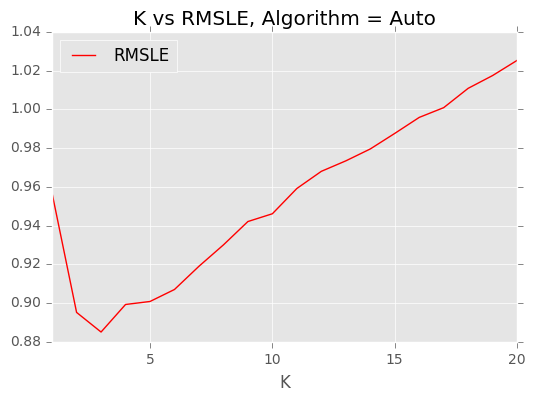

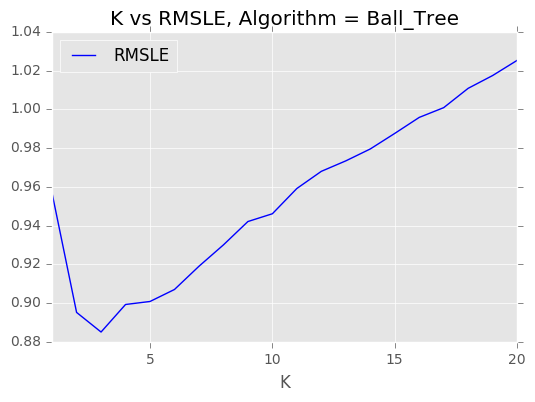

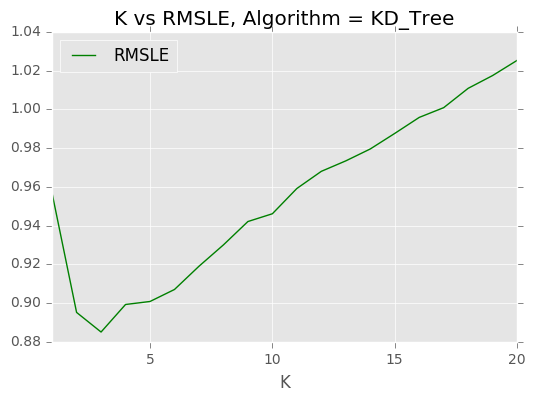

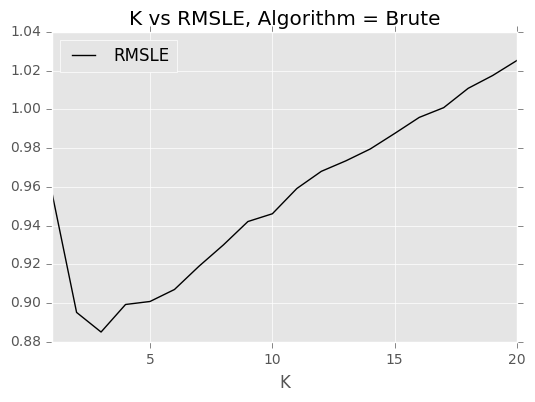

In [95]:
# Plot the RMSLE

res_rmsle=np.array(all_var_KNNResults)
df = pd.DataFrame(data = res_rmsle[:,:], columns=["K", "Algs","RMSLE"])
df[['K','RMSLE']] = df[['K','RMSLE']].apply(pd.to_numeric)


autoDF = df.loc[df['Algs'] == 'auto']
autoDF[['K','RMSLE']] = autoDF[['K','RMSLE']].apply(pd.to_numeric)

ballDF = df.loc[df['Algs'] == 'ball_tree']
ballDF[['K','RMSLE']] = ballDF[['K','RMSLE']].apply(pd.to_numeric)

kdDF = df.loc[df['Algs'] == 'kd_tree']
kdDF[['K','RMSLE']] = kdDF[['K','RMSLE']].apply(pd.to_numeric)

bruteDF = df.loc[df['Algs'] == 'brute']
bruteDF[['K','RMSLE']] = bruteDF[['K','RMSLE']].apply(pd.to_numeric)

autoDF.plot(x='K', y='RMSLE', color = 'red', title='K vs RMSLE, Algorithm = Auto')
ballDF.plot(x='K', y='RMSLE', color = 'blue', title='K vs RMSLE, Algorithm = Ball_Tree')
kdDF.plot(x='K', y='RMSLE', color = 'green', title='K vs RMSLE, Algorithm = KD_Tree')
bruteDF.plot(x='K', y='RMSLE', color = 'black', title='K vs RMSLE, Algorithm = Brute')


# Final Analysis